In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#score agent needs for environment to be solved
SOLVED_SCORE = 195

In [37]:
class ReplaySet(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

# Play environment

In [39]:
#Make environment
env = gym.make('CartPole-v1')
replay_buffer = ReplaySet(MAX_STEPS, env.observation_space.shape, env.action_space.n)

In [40]:
done = False
state = env.reset()
scores = []

for _ in range(MAX_STEPS):
    state = env.reset()
    done = False
    score = 0
    while not done:
        # env.render()
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        replay_buffer.store_transition(state, action, reward, new_state, done)
        score += reward
        state = new_state
    scores.append(score)
env.close()

# Implement Actor
Actor is the policy $\pi$ that we play with. Is a neural network

In [56]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)

        return action_probs

    def select_action(self, state):
        #convert state to float tensor, add 1 dimension, allocate tensor on device
        state = torch.from_numpy(state).float().unsqueeze(0)

        #use network to predict action probabilities
        action_probs = self.forward(state)

        #sample an action using the probability distribution
        m = Categorical(action_probs)
        action = m.sample()

        #return action
        return action.item(), m.log_prob(action)

# Create critic

The critic is the value approximation. Start with a linear approximation.

In [67]:
#learned value function
class ValueFunction():

    #initialize with value function parameters
    def __init__(self, weight_vector):
        self.v = weight_vector

    #get value of given state
    def __call__(self, xs):
        val = torch.matmul(torch.transpose(self.v, 0, 1), xs)
        return val

# Play environment

In [68]:
actor = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)

#Init weight vectors, should be matrices of dimensions (input, output)
stdv = 1 / np.sqrt(env.observation_space.shape[0])
v = torch.Tensor(np.random.uniform(low=-stdv, high=stdv, size=(env.observation_space.shape[0], 1)))


In [84]:
done = False
state = env.reset()
scores = []
for _ in tqdm_notebook(range(100)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        # env.render()
        action, lp = actor.select_action(state)
        print(action)
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

/tmp/ipykernel_36347/3137317038.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

0


KeyboardInterrupt: 

In [80]:
w = actor.parameters
print(actor.input_layer.weight)

PolicyNetwork(
  (input_layer): Linear(in_features=4, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
)
Parameter containing:
tensor([[ 3.4143e-01, -1.9363e-01, -4.6286e-01,  1.3921e-01],
        [-1.7529e-01, -3.4824e-01, -1.5627e-01, -3.2823e-01],
        [-1.5682e-01,  2.5980e-01, -2.8010e-01,  6.4418e-02],
        [ 1.7503e-02,  2.6854e-01, -4.6977e-01, -8.8647e-02],
        [ 1.2762e-01, -4.9629e-01, -1.5556e-02,  2.0430e-01],
        [-2.8436e-02, -2.7054e-01,  2.9450e-01, -4.2084e-02],
        [ 3.3124e-01, -1.7953e-02, -4.1910e-03,  2.3000e-01],
        [ 4.4304e-01, -4.6263e-01, -1.0413e-01,  1.6626e-02],
        [-1.9383e-01,  2.9079e-01,  3.7113e-01, -1.3464e-01],
        [ 3.3480e-01,  3.8086e-01,  3.6029e-01,  1.1918e-01],
        [ 4.0779e-01, -1.6027e-01,  3.0854e-01, -4.2789e-01],
        [-4.8437e-01, -2.2555e-01,  1.4995e-01, -2.3852e-01],
        [ 4.5282e-01,  1.7453e-01,  2.9815e-01,  3.5195e-01],
        [-6.1956e-

# Print scores

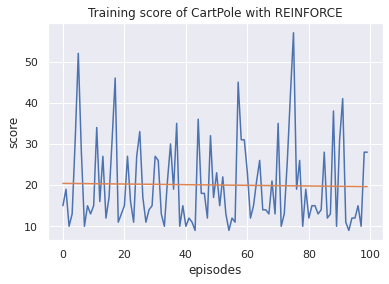

In [63]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of CartPole with REINFORCE')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [83]:
x=torch.tensor(2.0, requires_grad=True)
y=3*x**3+5*x**2+7*x+1
y.backward()
print(x.grad, y)

tensor(63.) tensor(59., grad_fn=<AddBackward0>)


In [92]:
#Using a neural network to learn our policy parameters
class ToyNetwork(nn.Module):

    #Takes in observations and outputs actions
    def __init__(self):
        super(ToyNetwork, self).__init__()
        self.input_layer = nn.Linear(1, 128)
        self.output_layer = nn.Linear(128, 1)

    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)

        #relu activation
        x = F.relu(x)

        #actions
        actions = self.output_layer(x)

        return actions

In [115]:
def testing_function (x):
    return 3*x**3+5*x**2+7*x+1

In [129]:
toy = ToyNetwork()
input =[]
input.append(torch.tensor([2.0], requires_grad=True))
input.append(torch.tensor([4.0], requires_grad=True))
input.append(torch.tensor([6.0], requires_grad=True))
input.append(torch.tensor([8.0], requires_grad=True))
optimizer = optim.Adam(toy.parameters(), lr=0.1)
for i in range(1000):
    acc_loss = 0
    for x in input:
        optimizer.zero_grad()
        pred_value = toy.forward(x.unsqueeze(dim=0))
        real_value = testing_function(x)
        loss = nn.functional.mse_loss(pred_value, real_value)
        loss.backward()
        optimizer.step()
        acc_loss = acc_loss + loss
print(acc_loss/1000)

/tmp/ipykernel_36347/2938344208.py:14: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(pred_value, real_value)


tensor(6.2180e-11, grad_fn=<DivBackward0>)


In [152]:
sdsa = 5.0
test_val= torch.tensor([sdsa], requires_grad=True)
pred_value = toy.forward(test_val.unsqueeze(dim=0))
print(pred_value)
testing_function (sdsa)

tensor([[537.7830]], grad_fn=<AddmmBackward0>)


536.0

In [153]:
pred_value.backward()
test_val.grad

tensor([287.0748])